In [20]:
#데이터 불러오기 + Resize 하기
from PIL import Image
import glob

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


In [21]:
import matplotlib.pyplot as plt
import os

In [22]:
#리사이즈 하기
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서 리사이즈

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissor"
resize_images(image_dir_path)

print("가위 이미지 resize 완료!")

# 바위 이미지 리사이즈
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/rock"
resize_images(image_dir_path)

print("바위 이미지 resize 완료!")

# 보 이미지 리사이즈
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/paper"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

100  images to be resized.
100  images resized.
가위 이미지 resize 완료!
100  images to be resized.
100  images resized.
바위 이미지 resize 완료!
100  images to be resized.
100  images resized.
보 이미지 resize 완료!


In [23]:
#가위, 바위, 보 불러와서 라벨링
import numpy as np

def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


라벨:  0


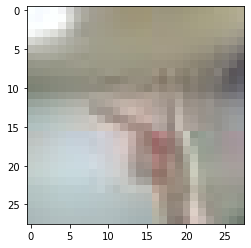

In [24]:
#저장된 이미지 불러보기
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

In [25]:
#딥러닝 네트워크 설계하기
import tensorflow as tf
from tensorflow import keras

model=keras.models.Sequential()
#sequential 방식을 사용하겠다!(대안 : functional)
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
#Conv2D의 첫번째 인자는 사용할 이미지 특징의 수. 여기선 16개를 고려하며 시작. input_shape를 통해 입력이미지의 형태 알려줌. 사이즈는 28X28로 위에서 맞춰주었고 사용할 샘플이 컬러사진이니 R,G,B로 3.
model.add(keras.layers.MaxPool2D(2,2))
#과적합 막기 위해서 풀링 계층 사용, 여기에서는 최댓값을 뽑아내는 맥스 풀링 사용.
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
#이젠 32개의 이미지 특징을 고려해 보겠다! 디테일한 것을 분석해야 할수록 숫자를 늘려주어라.
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
#이미지 데이터를 배열 형태로 만들어줌.
model.add(keras.layers.Dense(32, activation='relu'))
#첫 인자가 분류기에 사용되는 뉴런의 숫자. 만약 알파벳 대소문자로 52개 클래스를 분류해내야 한다면 64나 128 정도로 고려 가능.
model.add(keras.layers.Dense(3, activation='softmax'))
#마지막 Dense layer의 숫자는 결과적으로 분류해내야 할 클래스 수. 숫자라면 10, 가위바위보라면 3, 이런 식으로.

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                25632     
_________________________________________________________________
dense_3 (Dense)              (

In [26]:
#딥러닝 네트워크 학습시키기
print(x_train.shape)
#결과를 보면 이미 채널이 3으로 나와있으므로 굳이 추가할 필요 없음.

#epoch=10 : 10번 반복해서 학습하여라. epoch별로 인식 정확도 올라감.
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=25)

(300, 28, 28, 3)
Epoch 1/25
10/10 [==============================] - 0s 3ms/step - loss: 16.0963 - accuracy: 0.3500
Epoch 2/25
10/10 [==============================] - 0s 3ms/step - loss: 3.9025 - accuracy: 0.4233
Epoch 3/25
10/10 [==============================] - 0s 3ms/step - loss: 1.7299 - accuracy: 0.5933
Epoch 4/25
10/10 [==============================] - 0s 3ms/step - loss: 0.3797 - accuracy: 0.8467
Epoch 5/25
10/10 [==============================] - 0s 3ms/step - loss: 0.3187 - accuracy: 0.8833
Epoch 6/25
10/10 [==============================] - 0s 3ms/step - loss: 0.2847 - accuracy: 0.9100
Epoch 7/25
10/10 [==============================] - 0s 3ms/step - loss: 0.1479 - accuracy: 0.9567
Epoch 8/25
10/10 [==============================] - 0s 3ms/step - loss: 0.0860 - accuracy: 0.9667
Epoch 9/25
10/10 [==============================] - 0s 3ms/step - loss: 0.0621 - accuracy: 0.9833
Epoch 10/25
10/10 [==============================] - 0s 3ms/step - loss: 0.0383 - accuracy: 0.9933
E

In [27]:
#성능 테스트를 위한 테스트 데이터 리사이즈
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/scissor"
resize_images(image_dir_path)
print("가위 이미지 resize 완료!")

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/rock"
resize_images(image_dir_path)
print("바위 이미지 resize 완료!")

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test/paper"
resize_images(image_dir_path)
print("보 이미지 resize 완료!")

100  images to be resized.
100  images resized.
가위 이미지 resize 완료!
100  images to be resized.
100  images resized.
바위 이미지 resize 완료!
100  images to be resized.
100  images resized.
보 이미지 resize 완료!


학습데이터(x_train)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)
라벨:  0


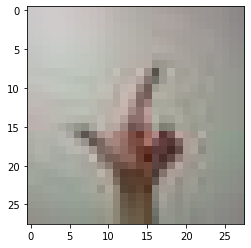

In [28]:
#라벨링
def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/test"
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

plt.imshow(x_test[0])
print('라벨: ', y_test[0])

In [29]:
#test_accuracy 측정

test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 0.7088 - accuracy: 0.7833
test_loss: 0.7088319063186646 
test_accuracy: 0.7833333611488342
